# Import and Config

In [1]:
from typing import Tuple
import pandas as pd
import spacy
import nltk
import numpy as np
from spacy.tokens import Token, Doc
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import wget as wget
import zipfile

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.embedding_composition_classes import (
    DepTreeBuilder,
    SpacyDependencyComposer
)
from discofuzz import (
    TensorStore,
    FuzzyFourierTensorTransformer
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
sim_metrics = [s.value for s in sim_metrics_enum]
n_components = 64
fuzzification_kernel_size = 16

spacy_model = spacy.load("en_core_web_sm")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
fuzzifier = FuzzyFourierTensorTransformer(kernel_size=fuzzification_kernel_size)
lemma_vectorizer = TensorStore(
    embedding_model=embedding_model,
    fuzzifier=fuzzifier,
    n_components=n_components
)

tree_builder = DepTreeBuilder(
    spacy_model=spacy_model,
    lemma_vectorizer=lemma_vectorizer
)

# Load Dataset

## Download dataset

In [4]:
# wget.download("https://pilehvar.github.io/wic/package/WiC_dataset.zip")

In [5]:
# Define the path to your zip file and the target directory for extraction
zip_file_path = 'WiC_dataset.zip'
extract_dir = 'WiC_dataset'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file in read mode ('r')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_dir)

print(f"Contents of '{zip_file_path}' extracted to '{extract_dir}'")

Contents of 'WiC_dataset.zip' extracted to 'WiC_dataset'


## Load dataset

In [6]:
# Load training data
train_df = pd.read_csv("./WiC_dataset/train/train.data.txt", sep="\t", header=None)
train_df = train_df[:sample_size]
train_df.columns = ["lemma", "pos", "index1-index2", "sent_1", "sent_2"]

# Load ground truth labels
train_labels = pd.read_csv("./WiC_dataset/train/train.gold.txt", header=None)
train_labels = train_labels[:sample_size]
train_labels.columns = ["is_related"]
train_labels["is_related"] = train_labels["is_related"].apply(lambda x: 1 if x == "T" else 0)

# clean dataframe
train_df["pos"] = train_df["pos"].apply(lambda x: x.lower())
train_df["tok_idx_1"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[0]))
train_df["tok_idx_2"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[1]))
train_df.drop("index1-index2", axis=1, inplace=True)

train_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4
4,academy,n,The Academy of Music .,The French Academy .,1,2


# Vectorize, Fuzzify Dataset

## Vectorize, fuzzify

In [7]:
embedding_dict = dict()

# embed all sentences
all_sent_embeddings = list()
for j in [1, 2]:
    sents = train_df[f"sent_{j}"].to_list()
    sent_embeddings = embedding_model.encode(sents)
    all_sent_embeddings.append(sent_embeddings)
    embedding_dict[f"sent_{j}_embedding"] = list(sent_embeddings)

all_sent_embeddings = np.row_stack(all_sent_embeddings)
print(all_sent_embeddings.shape)

(10856, 384)


In [9]:
# fit all the dimensionality reduction models
lemma_vectorizer.dim_reduc.fit_transform(all_sent_embeddings)
lemma_vectorizer.fitted = True
lemma_vectorizer.populate_with_wn_defaults()

Initializing TensorStore instance with wordnet lemma embeddings as defaults...
Embedding all the wordnet lemmas...
Performing dimensionality reduction on all the wordnet lemmas...
Fuzzifying all the dimensionality-reduced wordnet lemmas...
Getting fuzzy tensor embeddings for all the wordnet synsets...
Enriching fuzzified lemma tensors with fuzzified synset tensors...


In [10]:
# extract all relevant dependency branches
for i in [1, 2]:
    embedding_dict[f"branch_text_{i}"] = train_df.apply(lambda x: tree_builder.extract_branch(x, i), axis=1)

In [11]:
# reset lemma_vectorizer dim_reduc model
embedding_dict[f"branch_tuple_embedding_1_PCA"] = embedding_dict[f"branch_text_1"].apply(lambda x: tree_builder.get_branch_tuple_embedding(x))
embedding_dict[f"branch_tuple_embedding_2_PCA"] = embedding_dict[f"branch_text_2"].apply(lambda x: tree_builder.get_branch_tuple_embedding(x))

In [12]:
embedding_df = pd.DataFrame.from_dict(embedding_dict)
embedding_df = pd.concat([train_df, embedding_df], axis=1)
embedding_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2,sent_1_embedding,sent_2_embedding,branch_text_1,branch_text_2,branch_tuple_embedding_1_PCA,branch_tuple_embedding_2_PCA
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1,"[0.015941849, 0.05502, -0.011962676, 0.0465051...","[0.013950544, -0.00032918624, 0.10370384, -0.0...","({\n ""text"": ""carry"",\n ""pos_"": ""VERB""\n...","({\n ""text"": ""carries"",\n ""pos_"": ""VERB""...","([[(-4.2722863e-06+1.8618126e-06j), (-4.083744...","([[(2.3346628e-07+7.779621e-06j), (1.0704298e-..."
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6,"[0.06283063, -0.03421775, 0.043997858, -0.0236...","[0.09026999, -0.022930706, -0.047347587, -0.00...","({\n ""text"": ""go"",\n ""pos_"": ""VERB""\n}, ...","({\n ""text"": ""think"",\n ""pos_"": ""VERB""\n...","([[(-1.7180801e-06-1.0551053e-06j), (-2.221241...","([[(-5.436494e-06-4.5336265e-08j), (-5.4780867..."
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2,"[0.006467421, 0.078219935, -0.0016844971, -0.0...","[0.0024547558, 0.040336337, 0.08594136, 0.0261...","({\n ""text"": ""Break"",\n ""pos_"": ""VERB""\n...","({\n ""text"": ""broke"",\n ""pos_"": ""VERB""\n...","([[(-3.8165654e-06+1.8809534e-07j), (-3.896705...","([[(-3.8165654e-06+1.8809534e-07j), (-3.896705..."
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4,"[0.009509483, 0.12864761, -0.0009284174, 0.020...","[0.02304507, 0.016278433, 0.08679293, 0.019958...","({\n ""text"": ""with"",\n ""pos_"": ""ADP""\n},...","({\n ""text"": ""filled"",\n ""pos_"": ""VERB""\...","([[(-6.194635e-06-5.2598175e-06j), (-7.33805e-...","([[(-4.903192e-07-4.204905e-07j), (-9.857179e-..."
4,academy,n,The Academy of Music .,The French Academy .,1,2,"[-0.025275964, -0.03941193, -0.03450919, 0.028...","[-0.042090412, 0.0012605016, -0.030817574, -0....","({\n ""text"": ""Academy"",\n ""pos_"": ""PROPN...","({\n ""text"": ""Academy"",\n ""pos_"": ""PROPN...","([[(9.420569e-07+1.8625086e-06j), (1.0671894e-...","([[(9.420569e-07+1.8625086e-06j), (1.0671894e-..."


## Compose fuzzy embeddings

In [13]:
def get_fuzzy_emb_col(s:str, i:int):
    return f"sent_{i}_fuzzy_{s}"

In [14]:
# from discofuzz.SpacyDependencyComposer import SpacyDependencyComposer

# temporarily disable embedding cache
lemma_vectorizer.cache_embeddings = False

print(f"Getting compositional embeddings in PCA-reduced space...")
# reset lemma_vectorizer dim_reduc model
tup_emb_args_1 = embedding_df[[f"branch_tuple_embedding_1_PCA", "pos"]].apply(lambda x: tuple(x), axis=1)
tup_emb_args_2 = embedding_df[[f"branch_tuple_embedding_2_PCA", "pos"]].apply(lambda x: tuple(x), axis=1)

# get compositional embeddings for glosses using different strategies
for s in STRATEGIES:
  print(f"\tComposing embeddings with {s} approach...")
  # get baseline sentence fuzzy embeddings
  if s is None:
    sent_1_embs = embedding_df["sent_1"].apply(lambda x: lemma_vectorizer._embed_text(x))
    sent_2_embs = embedding_df["sent_2"].apply(lambda x: lemma_vectorizer._embed_text(x))
  
  # apply strategy
  else:
    composer = SpacyDependencyComposer(
        strategy=s,
        fuzzifier=fuzzifier
    )
    sent_1_embs = tup_emb_args_1.apply(lambda x: composer(x[0], x[1]))
    sent_2_embs = tup_emb_args_2.apply(lambda x: composer(x[0], x[1]))
  
  # compose embeddings
  embedding_df[get_fuzzy_emb_col(s, 1)] = sent_1_embs
  embedding_df[get_fuzzy_emb_col(s, 2)] = sent_2_embs

# re-enable embedding cache
lemma_vectorizer.cache_embeddings = True

Getting compositional embeddings in PCA-reduced space...
	Composing embeddings with None approach...
	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


In [15]:
embedding_df.columns

Index(['lemma', 'pos', 'sent_1', 'sent_2', 'tok_idx_1', 'tok_idx_2',
       'sent_1_embedding', 'sent_2_embedding', 'branch_text_1',
       'branch_text_2', 'branch_tuple_embedding_1_PCA',
       'branch_tuple_embedding_2_PCA', 'sent_1_fuzzy_None',
       'sent_2_fuzzy_None', 'sent_1_fuzzy_mean', 'sent_2_fuzzy_mean',
       'sent_1_fuzzy_intersection+mean', 'sent_2_fuzzy_intersection+mean',
       'sent_1_fuzzy_intersection+union', 'sent_2_fuzzy_intersection+union',
       'sent_1_fuzzy_intersection+intersection',
       'sent_2_fuzzy_intersection+intersection',
       'sent_1_fuzzy_selective_intersection+mean',
       'sent_2_fuzzy_selective_intersection+mean',
       'sent_1_fuzzy_selective_intersection+union',
       'sent_2_fuzzy_selective_intersection+union',
       'sent_1_fuzzy_selective_intersection+intersection+mean',
       'sent_2_fuzzy_selective_intersection+intersection+mean'],
      dtype='object')

In [16]:
# embedding_df[embedding_df["sent_1_fuzzy_intersection+union"].isna()][:10]

# Evaluate model

In [17]:
def normalize_about_median(data):
    data = (data - data.min()) / (data.max() - data.min())
    return data - data.median()

## Get relatedness scores

In [18]:
sims_df = pd.DataFrame()

In [19]:
# get compositional embeddings for glosses using:
#   ALL composition strategies,
#   ALL similarity metrics
for sim_metric in sim_metrics_enum:
  print(f"\n\t=== Computing similarities with {sim_metric} metric ===")
  for s in STRATEGIES:
    print(f"\t\tGetting compositional embedding relatedness scores for {s} approach...")
    sims = list()
    for i, row in embedding_df.iterrows():
      try:
        sims.append(fuzzifier.similarity(
            row[get_fuzzy_emb_col(s, 1)],
            row[get_fuzzy_emb_col(s, 2)],
            method=sim_metric,
        ))
      except Exception as e:
        print(row)
        raise e
    
    col = f"fuzzy_{s}_PCA_{sim_metric.value}_sim"
    # normalize similarity scores
    sims_df[col] = normalize_about_median(pd.Series(sims))


	=== Computing similarities with SIMILARITY_METRICS.COS metric ===
		Getting compositional embedding relatedness scores for None approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for intersection+intersection approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for selective_intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for selective_intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")


		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  values = values.astype("f8")



	=== Computing similarities with SIMILARITY_METRICS.W1 metric ===
		Getting compositional embedding relatedness scores for None approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...

	=== Computing similarities with SIMILARITY_METRICS.W2 metric ===
		Getting compositional embedding relatedness scores for None approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for intersection+intersection approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for selective_intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for selective_intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)



	=== Computing similarities with SIMILARITY_METRICS.Q metric ===
		Getting compositional embedding relatedness scores for None approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...


In [20]:
import numpy as np

# Add sentence embedding baseline (full sentence encoding)
sent_emb_sims = list()
for i, row in embedding_df.iterrows():
  sent_emb_sims.append(cosine_similarity(
      row["sent_1_embedding"].reshape((1, -1)),
      row["sent_2_embedding"].reshape((1, -1)),
  ))
  
sims_df["sent_emb_cos_sim"] = normalize_about_median(pd.Series(np.array(sent_emb_sims).reshape(-1, )))

In [21]:
sims_df.head()

,fuzzy_None_PCA_cos_sim,fuzzy_mean_PCA_cos_sim,fuzzy_intersection+mean_PCA_cos_sim,fuzzy_intersection+union_PCA_cos_sim,fuzzy_intersection+intersection_PCA_cos_sim,fuzzy_selective_intersection+mean_PCA_cos_sim,fuzzy_selective_intersection+union_PCA_cos_sim,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim,fuzzy_None_PCA_wasserstein-1_sim,fuzzy_mean_PCA_wasserstein-1_sim,...,fuzzy_selective_intersection+intersection+mean_PCA_wasserstein-2_sim,fuzzy_None_PCA_quantum_sim,fuzzy_mean_PCA_quantum_sim,fuzzy_intersection+mean_PCA_quantum_sim,fuzzy_intersection+union_PCA_quantum_sim,fuzzy_intersection+intersection_PCA_quantum_sim,fuzzy_selective_intersection+mean_PCA_quantum_sim,fuzzy_selective_intersection+union_PCA_quantum_sim,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim,sent_emb_cos_sim
0,-0.093658+0.060374j,-0.189312+0.000086j,-0.001828-0.215914j,-0.000855-0.317432j,-0.000855-0.317432j,0.005111+0.027479j,0.004015+0.024630j,0.005111+0.027479j,-0.154709,-0.174905,...,-0.009096,-0.202366,-0.190927,-0.000091,-0.000127,-0.000127,0.000065,0.000073,0.000065,-0.124524
1,0.012257+0.047863j,0.046171-0.138133j,0.000943-0.217102j,0.000569-0.314778j,0.000569-0.314778j,0.004671+0.026863j,0.004164+0.025685j,0.004671+0.026863j,-0.047798,0.186155,...,0.020490,-0.052399,0.105652,-0.000137,0.000089,0.000089,0.000191,0.000205,0.000191,-0.122760
2,0.049383+0.072855j,0.053782-0.137756j,-0.010318-0.207772j,-0.004250-0.299528j,-0.004250-0.299528j,0.005037+0.027182j,0.007019+0.025382j,0.005037+0.027182j,-0.132726,0.157302,...,0.022359,-0.161388,0.102466,-0.001031,-0.001202,-0.001202,0.000172,0.000122,0.000172,-0.082443
3,-0.162277+0.003499j,-0.024699-0.064736j,-0.000167-0.214160j,-0.000195-0.314348j,-0.000195-0.314348j,-0.127126+0.038743j,-0.126579+0.038017j,-0.127126+0.038743j,-0.286544,-0.020476,...,-0.376362,-0.351795,-0.036042,0.000158,0.000135,0.000135,-0.004521,-0.004480,-0.004521,-0.101951
4,0.034591+0.078243j,0.052128-0.139461j,0.000168-0.213799j,0.000083-0.314028j,0.000083-0.314028j,-0.058510+0.012611j,-0.055131+0.020933j,-0.058510+0.012611j,0.060609,0.147943,...,-0.374297,0.075072,0.100999,0.000118,0.000107,0.000107,-0.001787,-0.001732,-0.001787,0.275158


In [22]:
# Add SBERT token-level baseline (average of individual token embeddings)
sbert_token_avg_sims = list()
for i, row in embedding_df.iterrows():
    # Process sentence 1
    doc_1 = spacy_model(row["sent_1"])
    token_embs_1 = [
        embedding_model.encode(token.text)
        for token in doc_1
        if not token.is_punct
    ]
    avg_emb_1 = tf.reduce_mean(token_embs_1, axis=0) if token_embs_1 else tf.zeros(384)
    avg_emb_1 = np.array(avg_emb_1)

    # Process sentence 2
    doc_2 = spacy_model(row["sent_2"])
    token_embs_2 = [
        embedding_model.encode(token.text)
        for token in doc_2
        if not token.is_punct
    ]
    avg_emb_2 = tf.reduce_mean(token_embs_2, axis=0) if token_embs_2 else tf.zeros(384)
    avg_emb_2 = np.array(avg_emb_2)
    
    # Calculate similarity
    sbert_token_avg_sims.append(cosine_similarity(
        avg_emb_1.reshape((1, -1)),
        avg_emb_2.reshape((1, -1))
    ))

In [23]:
sims_df["sbert_token_avg_cos_sim"] = normalize_about_median(pd.Series(np.array(sbert_token_avg_sims).reshape(-1, )))

sims_df["is_related"] = train_labels["is_related"].values

In [24]:
sims_df.head()

,fuzzy_None_PCA_cos_sim,fuzzy_mean_PCA_cos_sim,fuzzy_intersection+mean_PCA_cos_sim,fuzzy_intersection+union_PCA_cos_sim,fuzzy_intersection+intersection_PCA_cos_sim,fuzzy_selective_intersection+mean_PCA_cos_sim,fuzzy_selective_intersection+union_PCA_cos_sim,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim,fuzzy_None_PCA_wasserstein-1_sim,fuzzy_mean_PCA_wasserstein-1_sim,...,fuzzy_mean_PCA_quantum_sim,fuzzy_intersection+mean_PCA_quantum_sim,fuzzy_intersection+union_PCA_quantum_sim,fuzzy_intersection+intersection_PCA_quantum_sim,fuzzy_selective_intersection+mean_PCA_quantum_sim,fuzzy_selective_intersection+union_PCA_quantum_sim,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim,sent_emb_cos_sim,sbert_token_avg_cos_sim,is_related
0,-0.093658+0.060374j,-0.189312+0.000086j,-0.001828-0.215914j,-0.000855-0.317432j,-0.000855-0.317432j,0.005111+0.027479j,0.004015+0.024630j,0.005111+0.027479j,-0.154709,-0.174905,...,-0.190927,-0.000091,-0.000127,-0.000127,0.000065,0.000073,0.000065,-0.124524,-0.154867,0
1,0.012257+0.047863j,0.046171-0.138133j,0.000943-0.217102j,0.000569-0.314778j,0.000569-0.314778j,0.004671+0.026863j,0.004164+0.025685j,0.004671+0.026863j,-0.047798,0.186155,...,0.105652,-0.000137,0.000089,0.000089,0.000191,0.000205,0.000191,-0.122760,-0.057215,0
2,0.049383+0.072855j,0.053782-0.137756j,-0.010318-0.207772j,-0.004250-0.299528j,-0.004250-0.299528j,0.005037+0.027182j,0.007019+0.025382j,0.005037+0.027182j,-0.132726,0.157302,...,0.102466,-0.001031,-0.001202,-0.001202,0.000172,0.000122,0.000172,-0.082443,-0.278227,0
3,-0.162277+0.003499j,-0.024699-0.064736j,-0.000167-0.214160j,-0.000195-0.314348j,-0.000195-0.314348j,-0.127126+0.038743j,-0.126579+0.038017j,-0.127126+0.038743j,-0.286544,-0.020476,...,-0.036042,0.000158,0.000135,0.000135,-0.004521,-0.004480,-0.004521,-0.101951,-0.022025,1
4,0.034591+0.078243j,0.052128-0.139461j,0.000168-0.213799j,0.000083-0.314028j,0.000083-0.314028j,-0.058510+0.012611j,-0.055131+0.020933j,-0.058510+0.012611j,0.060609,0.147943,...,0.100999,0.000118,0.000107,0.000107,-0.001787,-0.001732,-0.001787,0.275158,0.036613,0


## Classify predictions based on similarity thresholding

In [25]:
sim_eval_df = pd.DataFrame()
for col in sims_df.columns:
    if col == "is_related":
        continue
    # normaize the 
    sim_eval_df[f"{col}_pred"] = sims_df[col] > 0
sim_eval_df["is_related"] = sims_df["is_related"]
sim_eval_df.head()

,fuzzy_None_PCA_cos_sim_pred,fuzzy_mean_PCA_cos_sim_pred,fuzzy_intersection+mean_PCA_cos_sim_pred,fuzzy_intersection+union_PCA_cos_sim_pred,fuzzy_intersection+intersection_PCA_cos_sim_pred,fuzzy_selective_intersection+mean_PCA_cos_sim_pred,fuzzy_selective_intersection+union_PCA_cos_sim_pred,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim_pred,fuzzy_None_PCA_wasserstein-1_sim_pred,fuzzy_mean_PCA_wasserstein-1_sim_pred,...,fuzzy_mean_PCA_quantum_sim_pred,fuzzy_intersection+mean_PCA_quantum_sim_pred,fuzzy_intersection+union_PCA_quantum_sim_pred,fuzzy_intersection+intersection_PCA_quantum_sim_pred,fuzzy_selective_intersection+mean_PCA_quantum_sim_pred,fuzzy_selective_intersection+union_PCA_quantum_sim_pred,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim_pred,sent_emb_cos_sim_pred,sbert_token_avg_cos_sim_pred,is_related
0,False,False,False,False,False,True,True,True,False,False,...,False,False,False,False,True,True,True,False,False,0
1,True,True,True,True,True,True,True,True,False,True,...,True,False,True,True,True,True,True,False,False,0
2,True,True,False,False,False,True,True,True,False,True,...,True,False,False,False,True,True,True,False,False,0
3,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,False,False,False,False,False,1
4,True,True,True,True,True,False,False,False,True,True,...,True,True,True,True,False,False,False,True,True,0


## Visualize similarities

C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


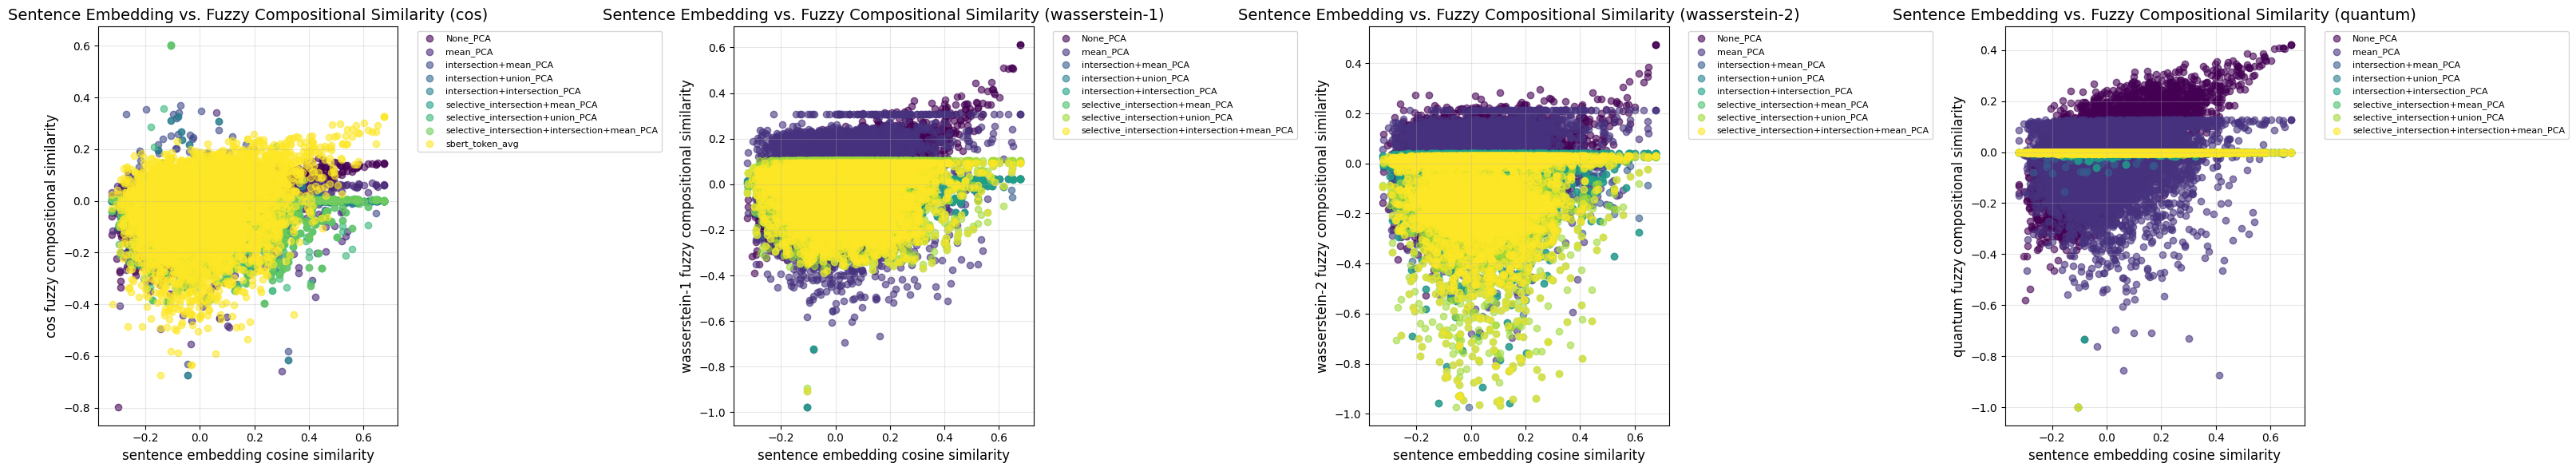

In [26]:
# Create subplots for each similarity metric
fig, axes = plt.subplots(1, len(sim_metrics), figsize=(8*len(sim_metrics), 6))
if len(sim_metrics) == 1:
    axes = [axes]

for metric_idx, sim_metric in enumerate(sim_metrics):
    ax = axes[metric_idx]
    
    # Get columns for this metric
    metric_cols = [col for col in sims_df.columns if col.endswith(f"{sim_metric}_sim")]
    
    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(metric_cols)))
    
    for i, col in enumerate(metric_cols):
        if col == "sent_emb_cos_sim":
            continue
        ax.scatter(
            x=sims_df["sent_emb_cos_sim"],
            y=sims_df[col],
            color=colors[i],
            label=col.replace(f"fuzzy_", "").replace(f"_{sim_metric}_sim", ""),
            alpha=0.6
        )
    
    ax.set_xlabel("sentence embedding cosine similarity", fontsize=12)
    ax.set_ylabel(f"{sim_metric} fuzzy compositional similarity", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    # ax.set_yscale("log")
    ax.set_title(f"Sentence Embedding vs. Fuzzy Compositional Similarity ({sim_metric})", fontsize=14)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix

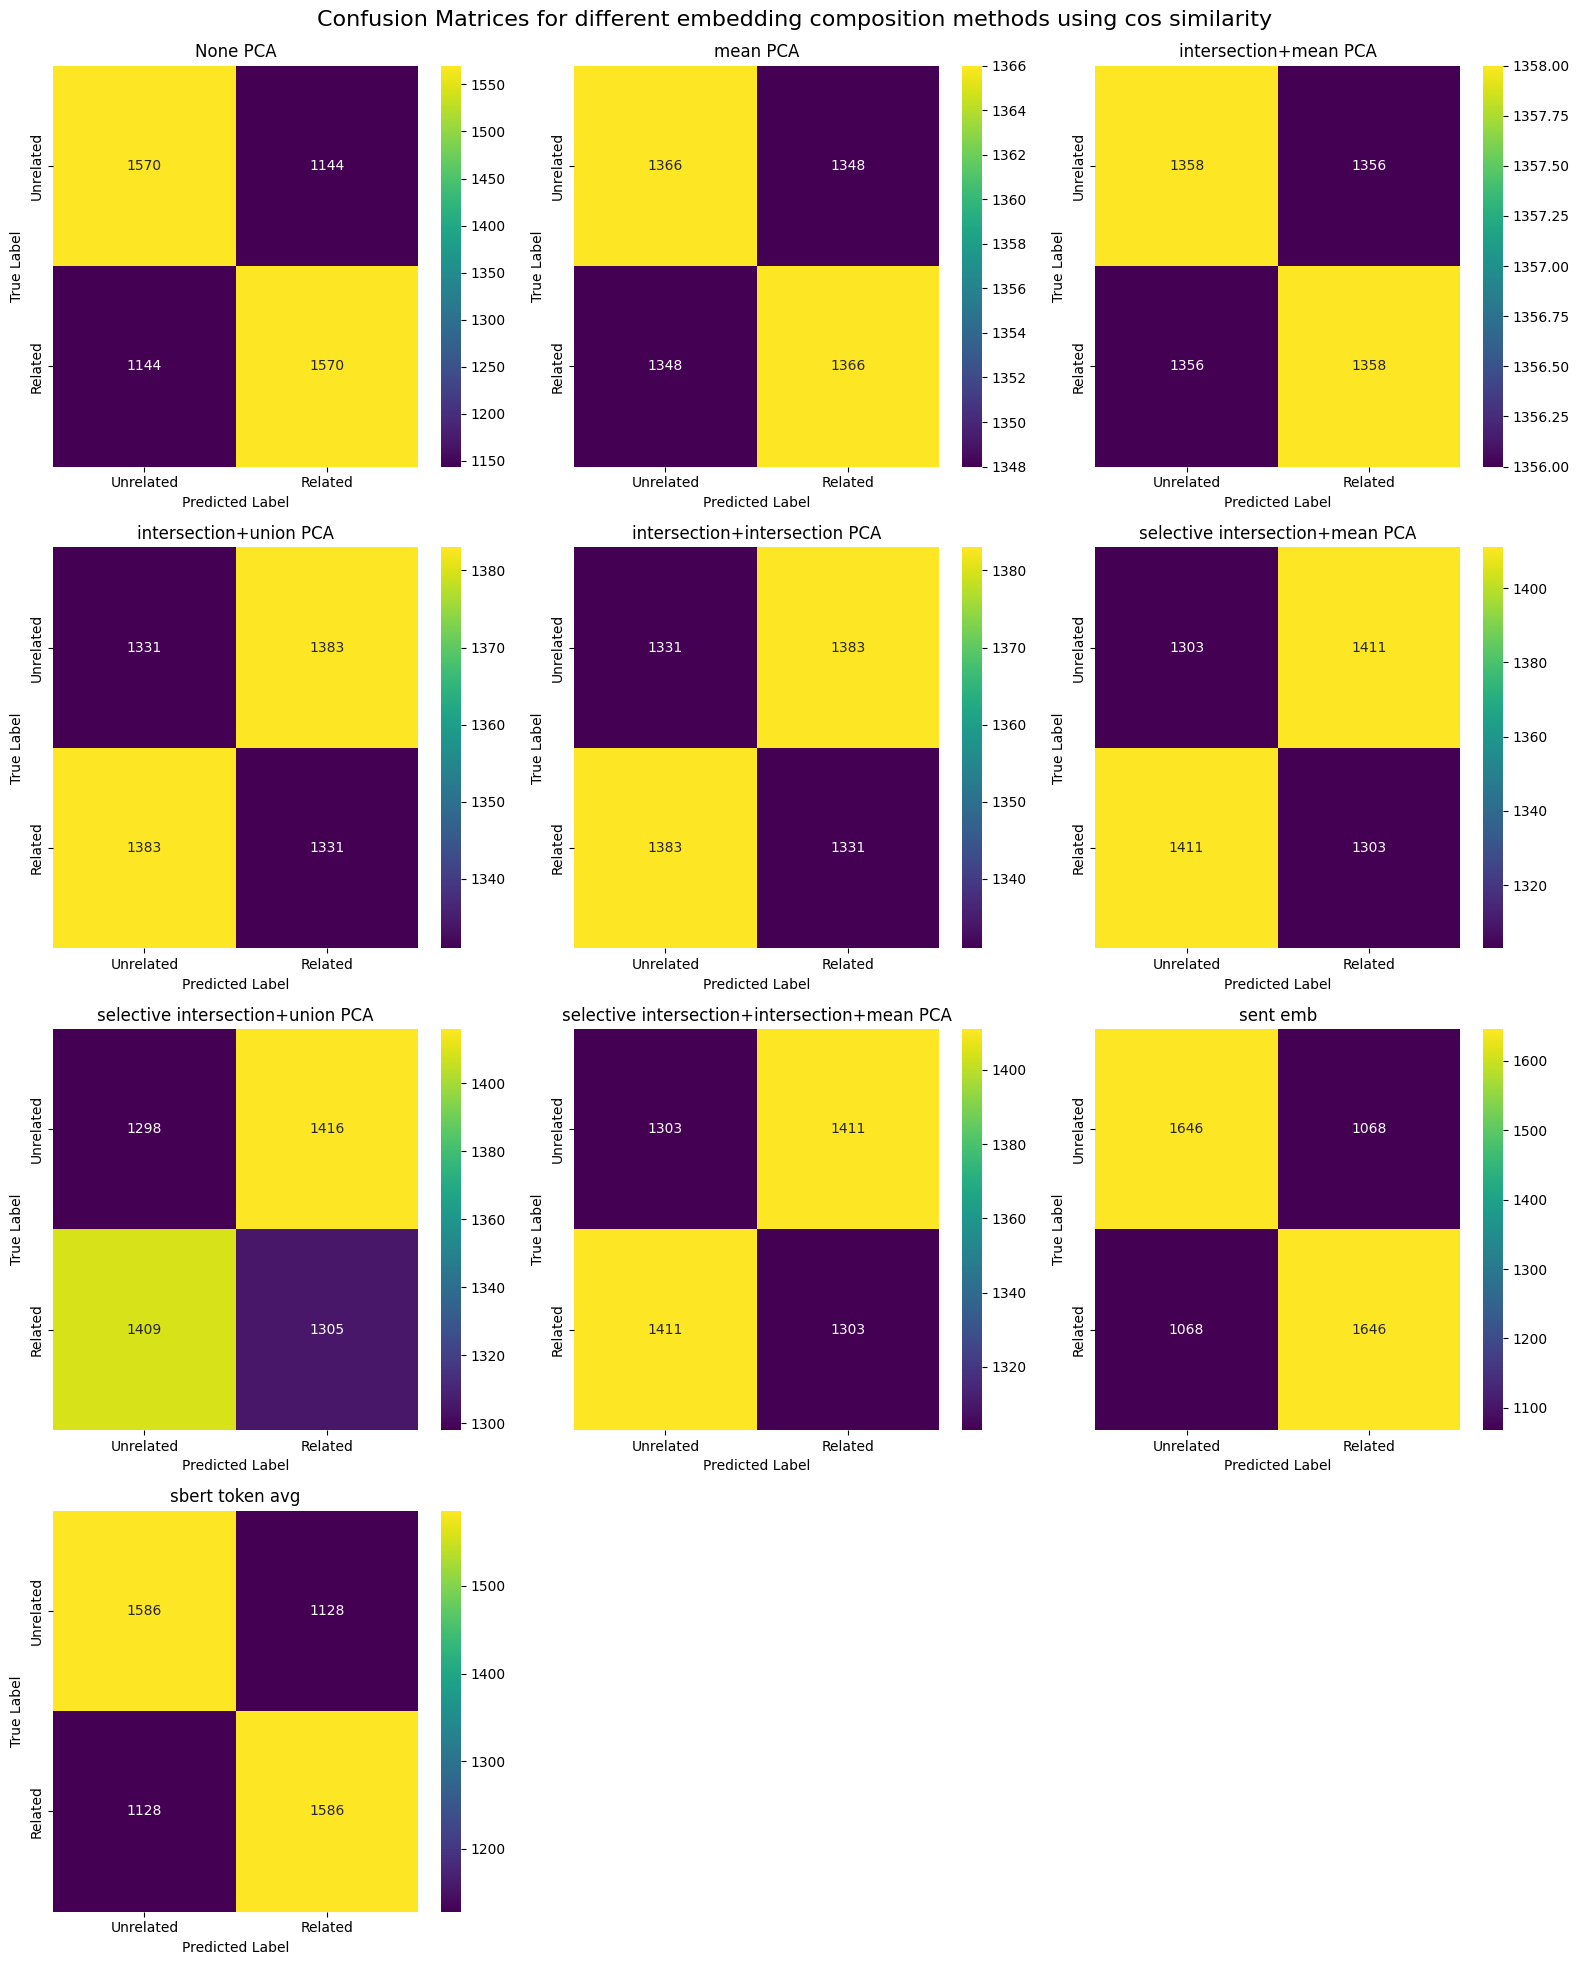

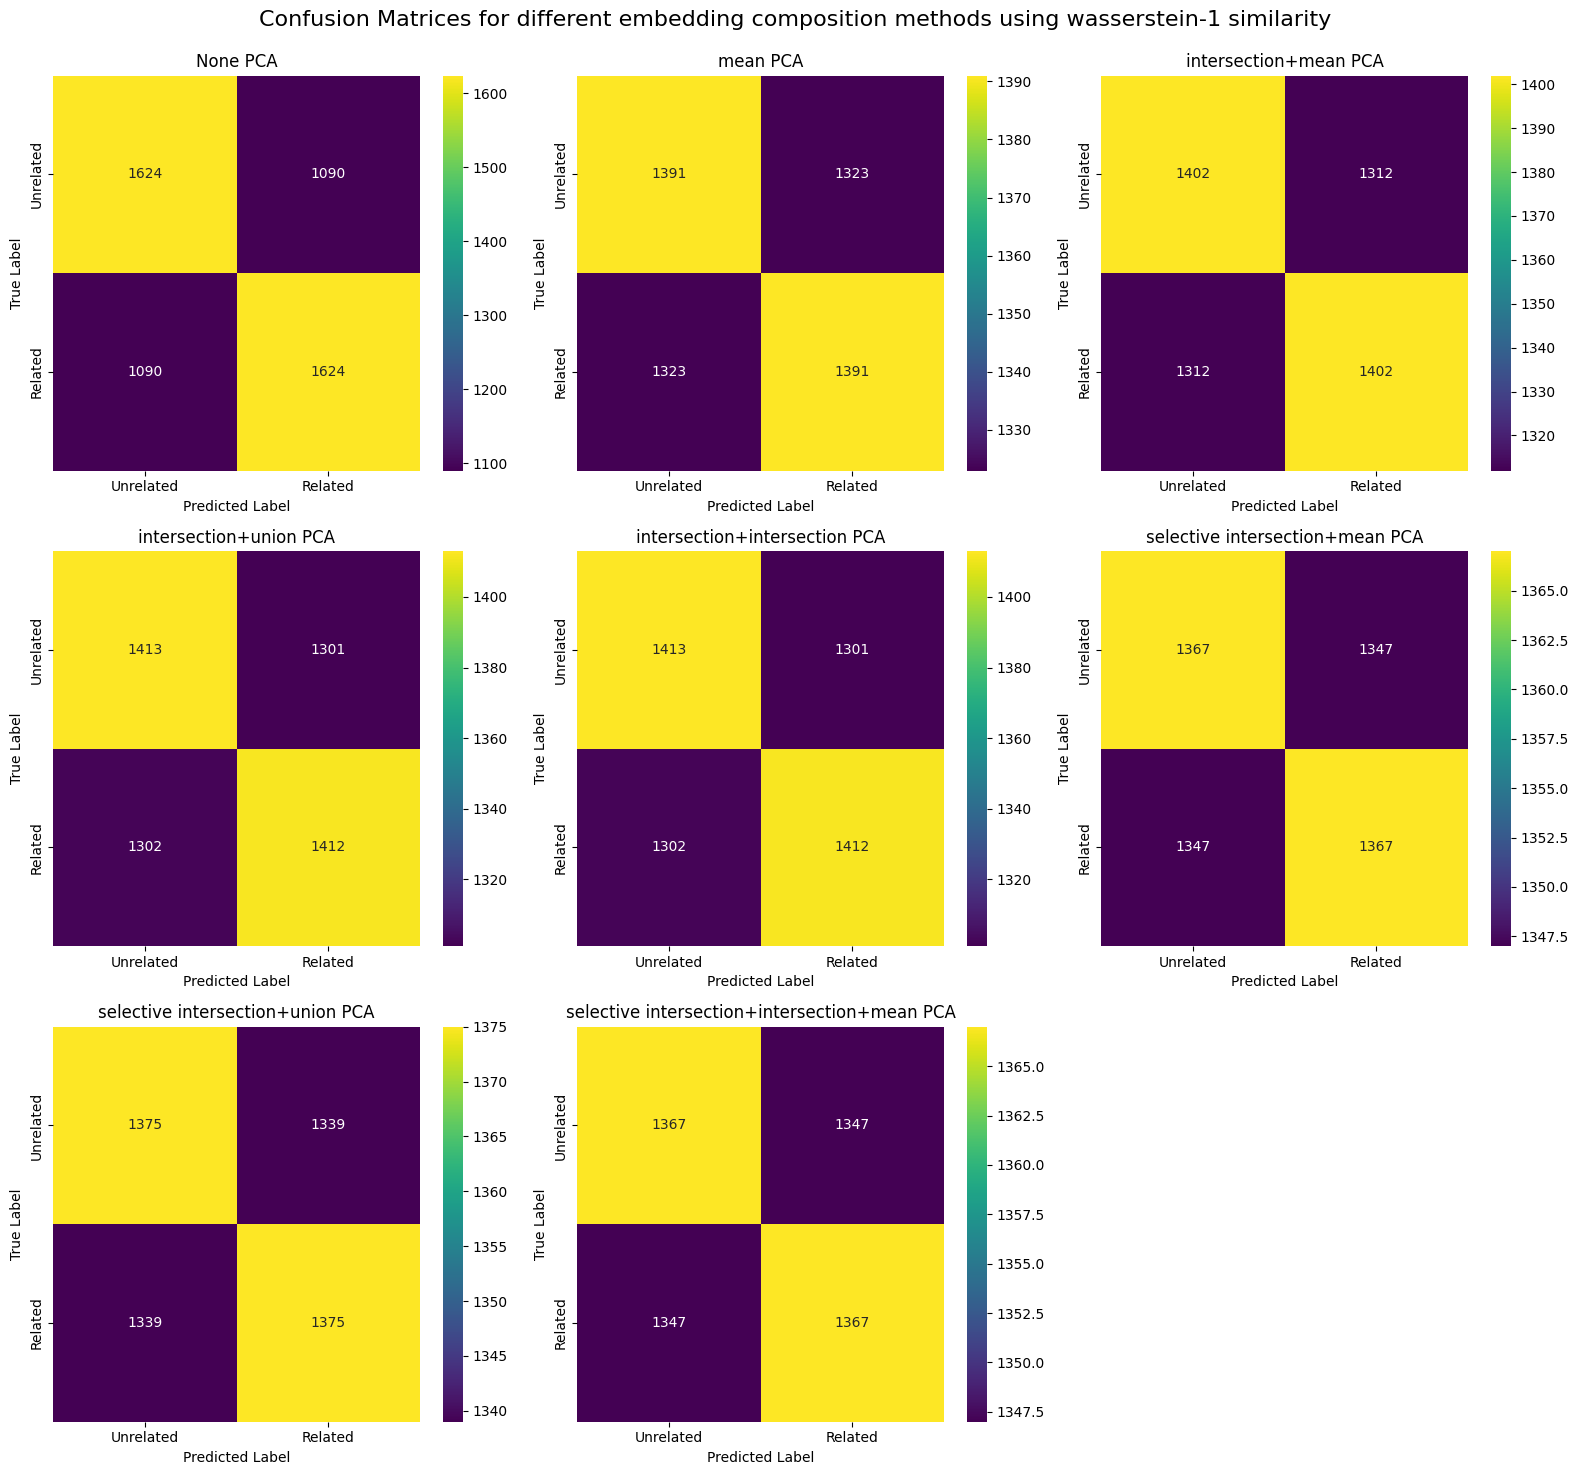

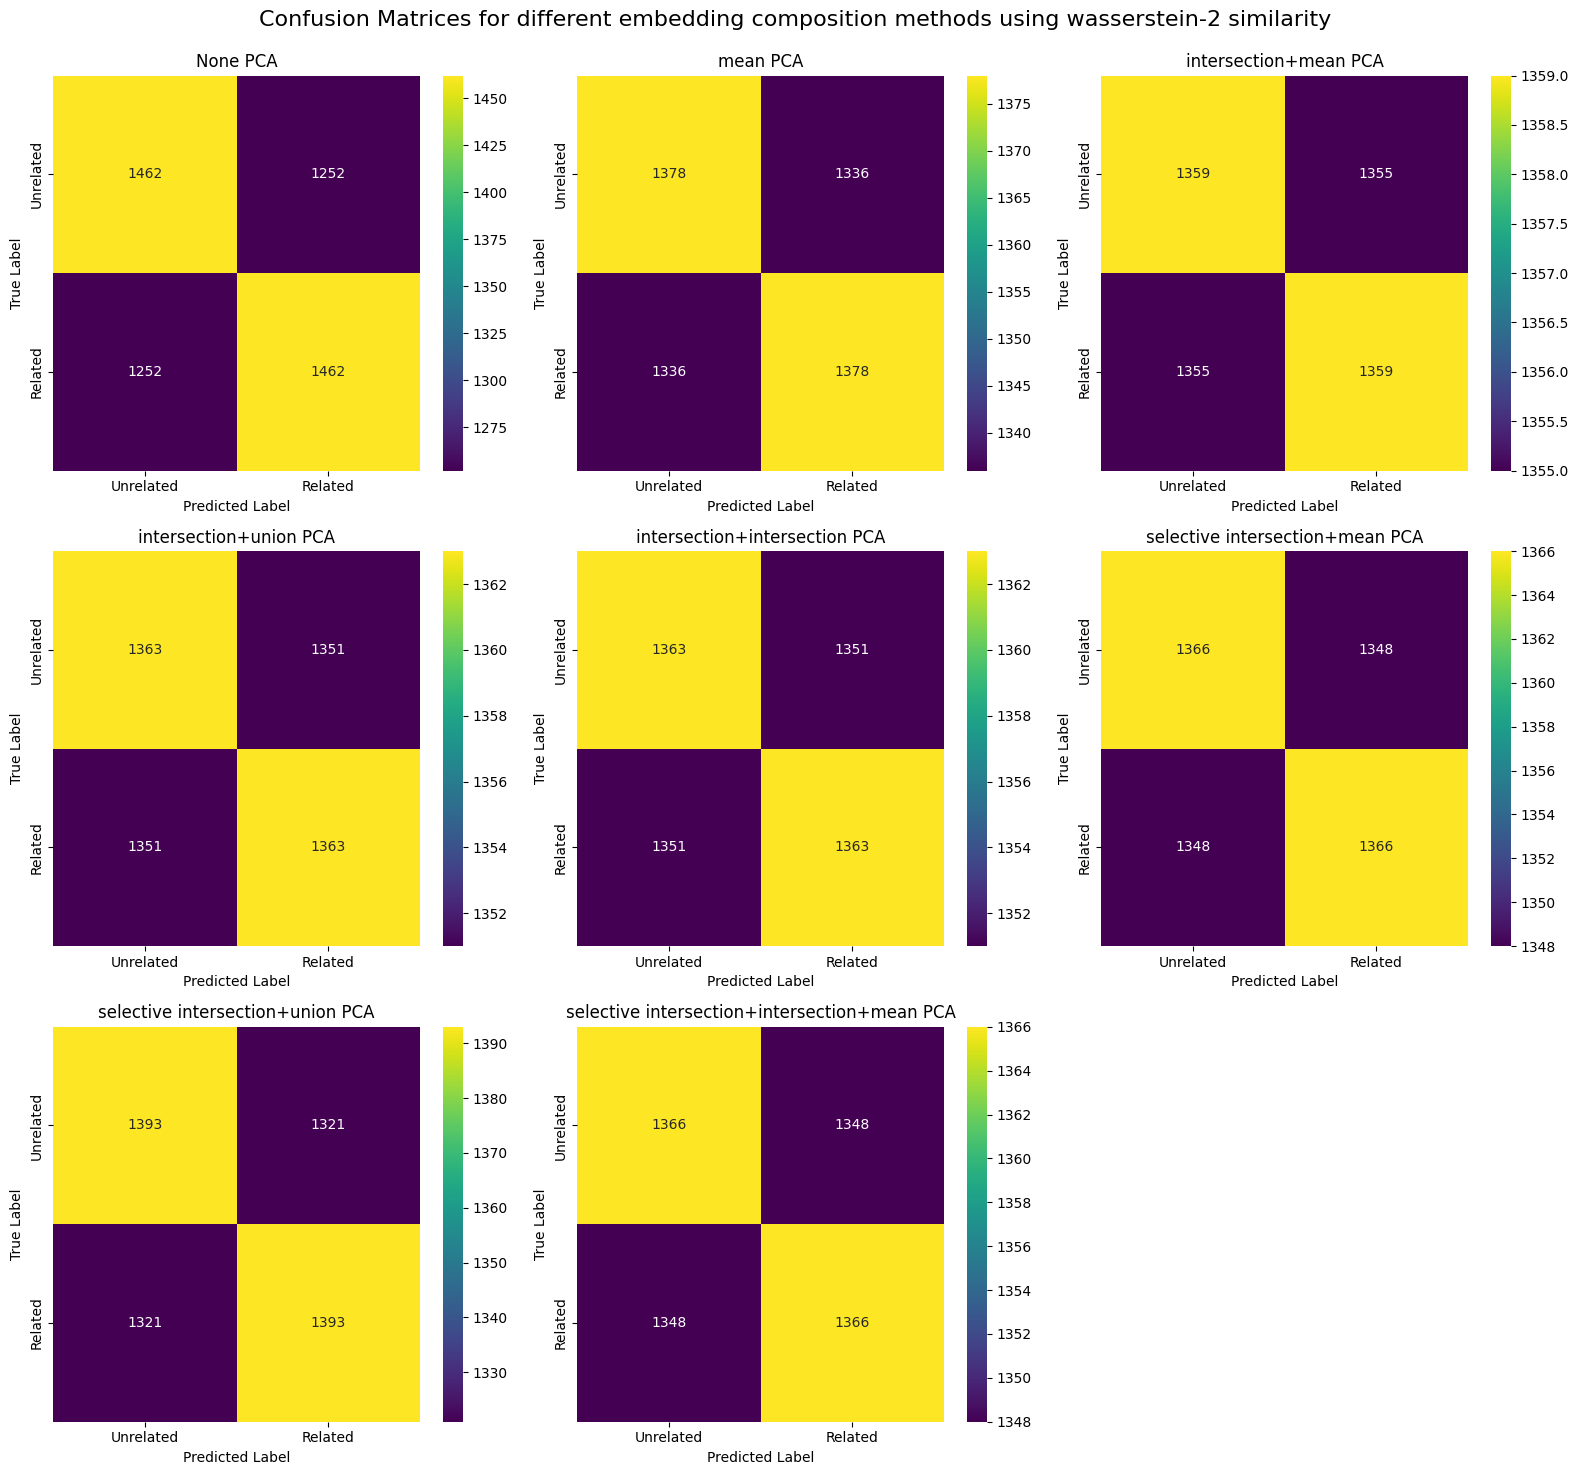

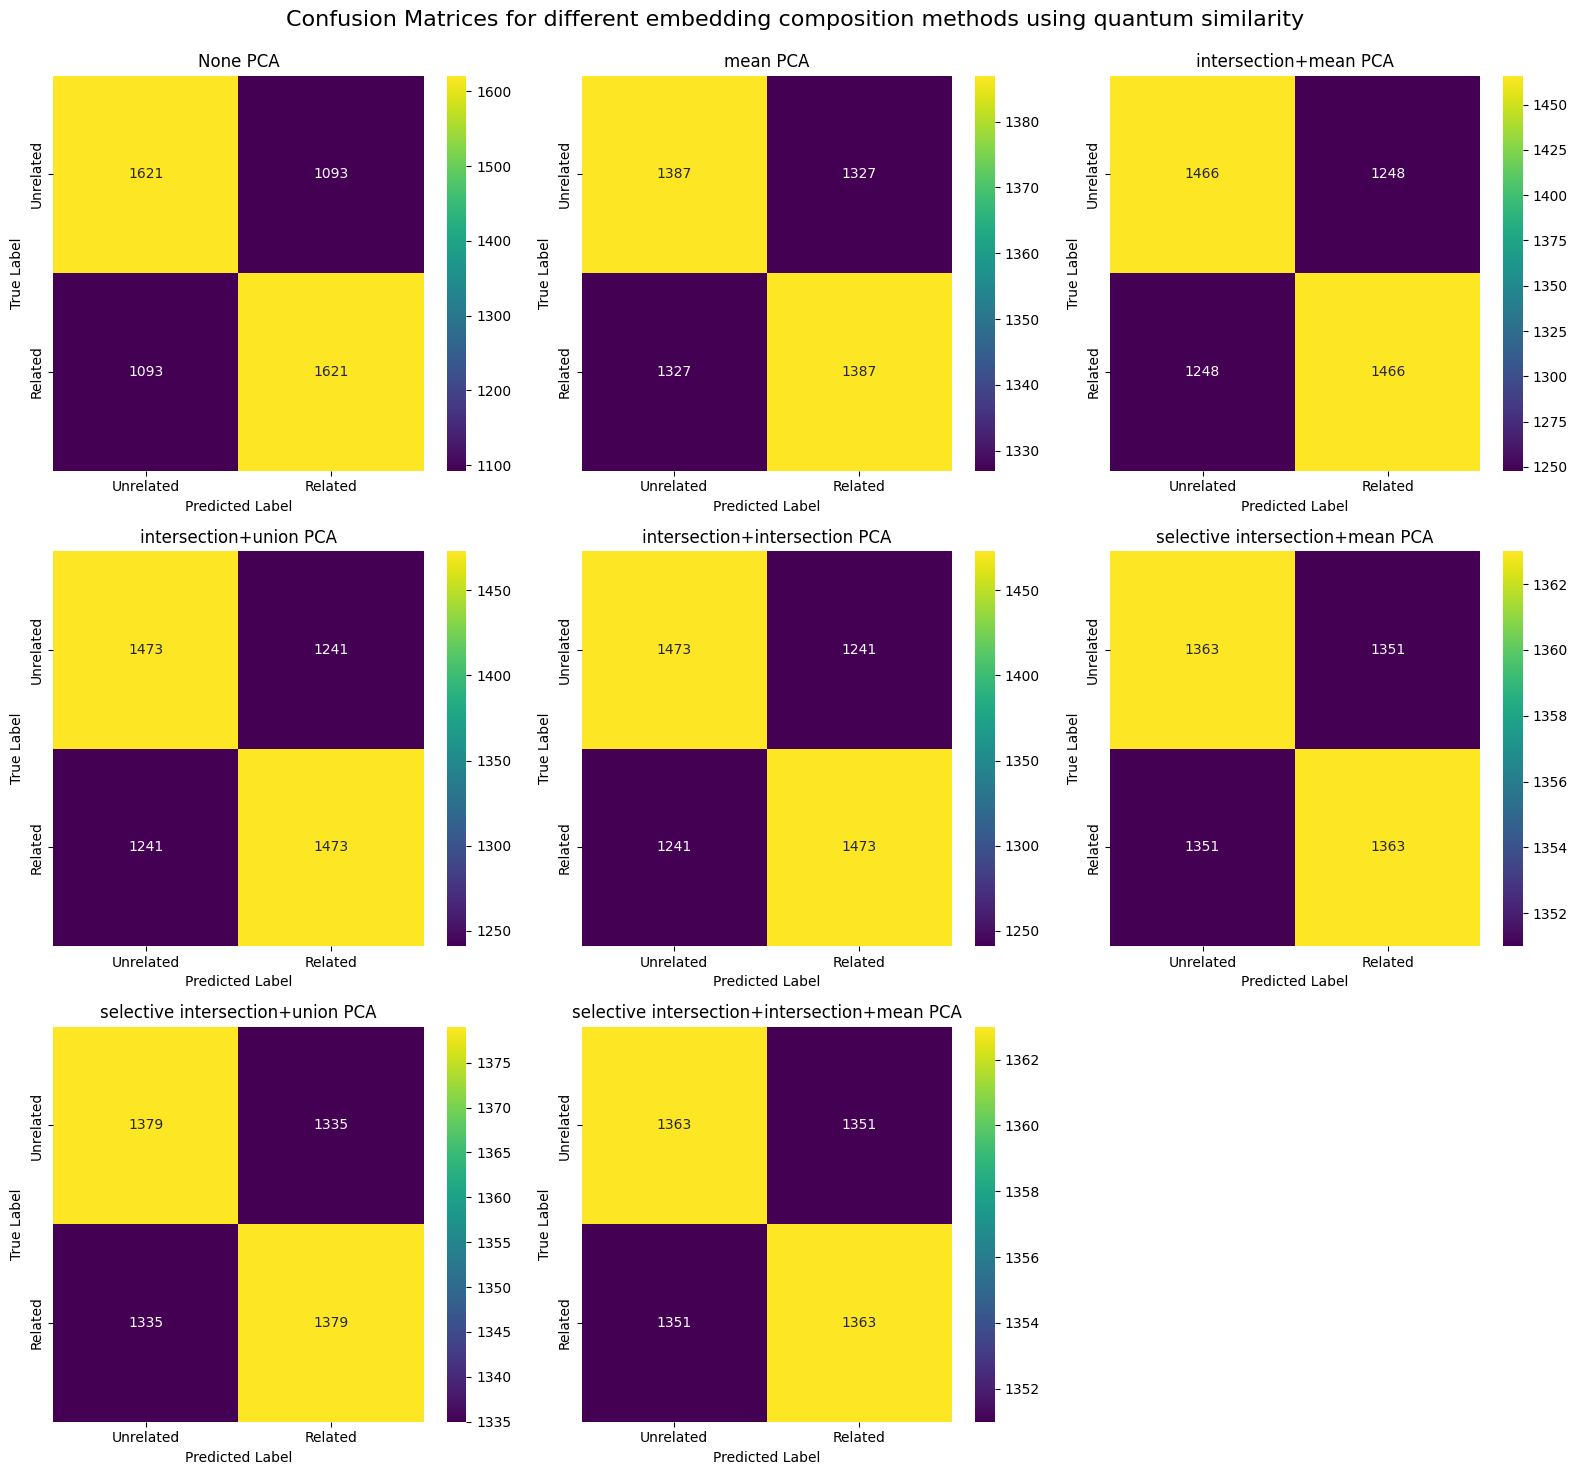

In [27]:
# Create confusion matrices for all metrics
for sim_metric in sim_metrics:
    # Get columns for this metric
    metric_cols = [col for col in sim_eval_df.columns if col.endswith(f"{sim_metric}_sim_pred")]
    
    if not metric_cols:
        continue
    
    # Calculate grid size
    n_cols = 3
    n_rows = int(np.ceil(len(metric_cols) / n_cols))
    
    plt.figure(figsize=(16, 5*n_rows))
    plt.suptitle(f"Confusion Matrices for different embedding composition methods using {sim_metric} similarity\n", fontsize=16)
    
    for i, col in enumerate(metric_cols):
        # Calculate confusion matrix
        cm = confusion_matrix(
            sim_eval_df['is_related'],
            sim_eval_df[col].astype(int)
        )

        # Plot confusion matrix
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='viridis',
            xticklabels=['Unrelated', 'Related'],
            yticklabels=['Unrelated', 'Related']
        )
        plt.title(f'{col.replace("fuzzy_", "").replace(f"_{sim_metric}_sim_pred", "").replace("_", " ")}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

## Correlation Coefficients

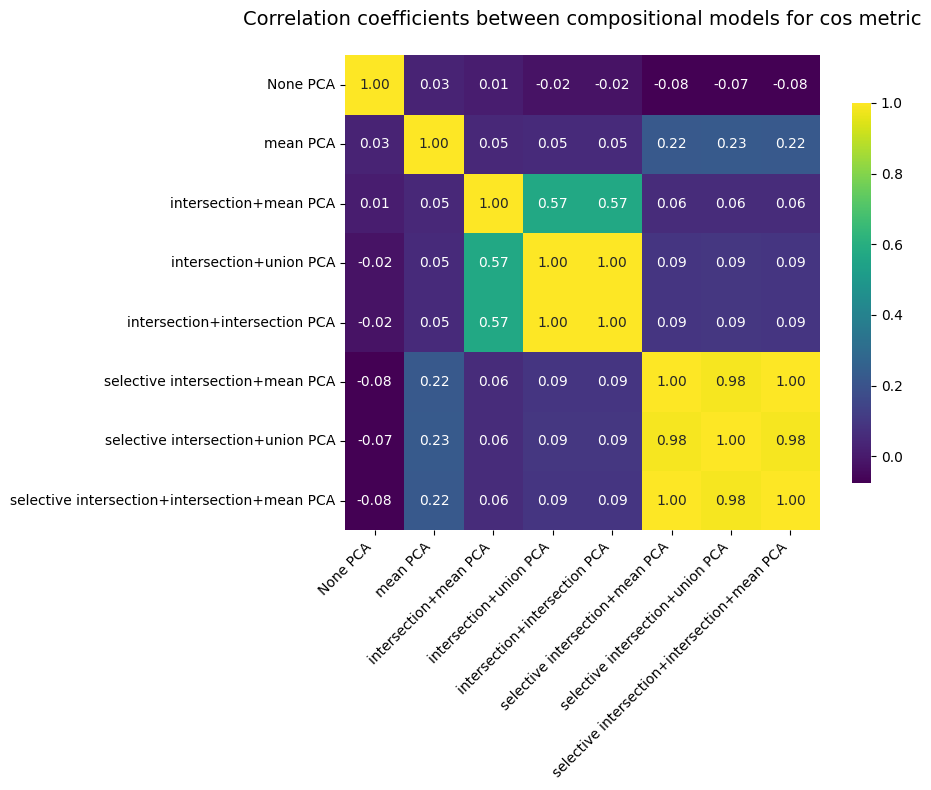

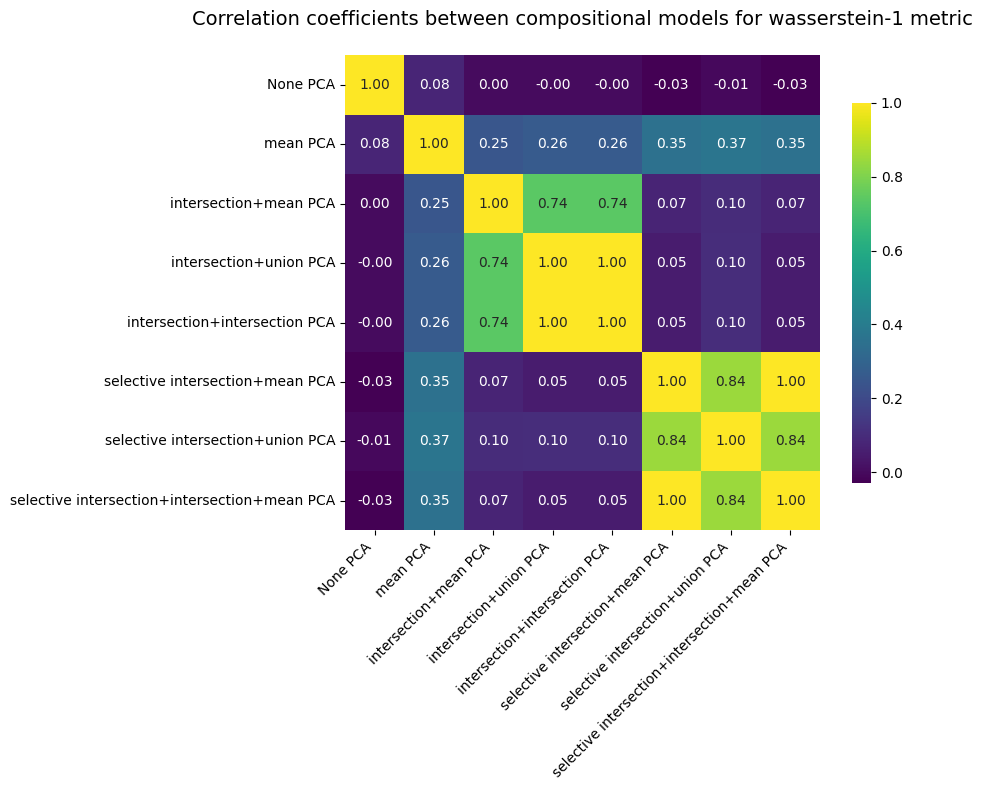

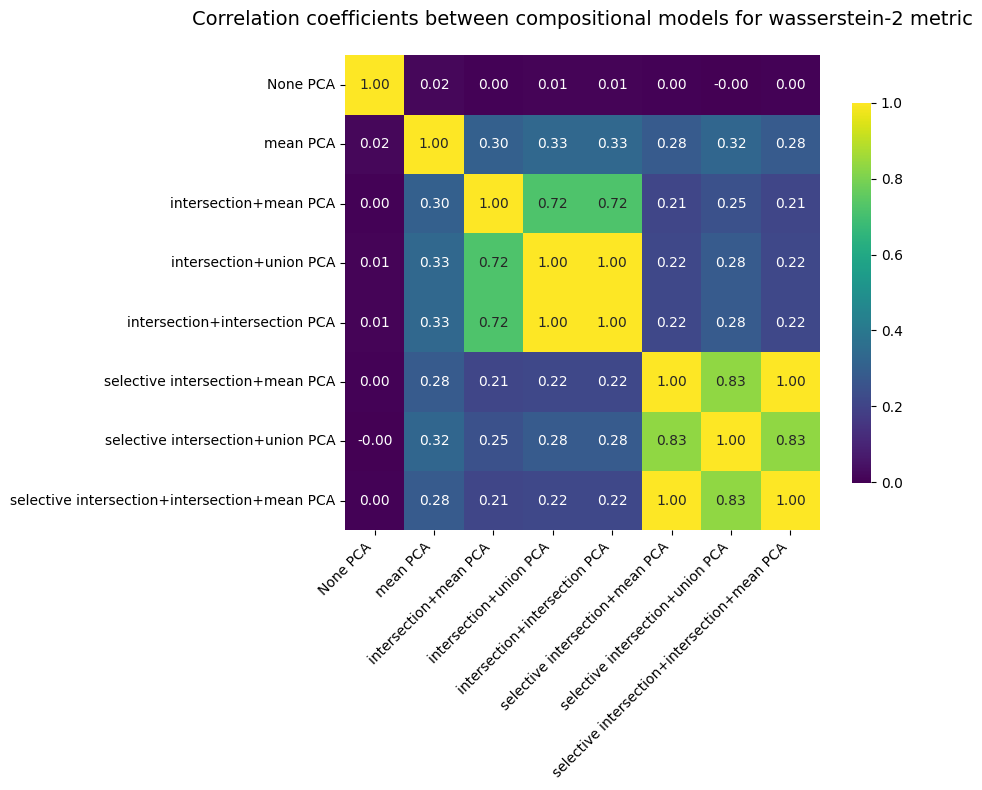

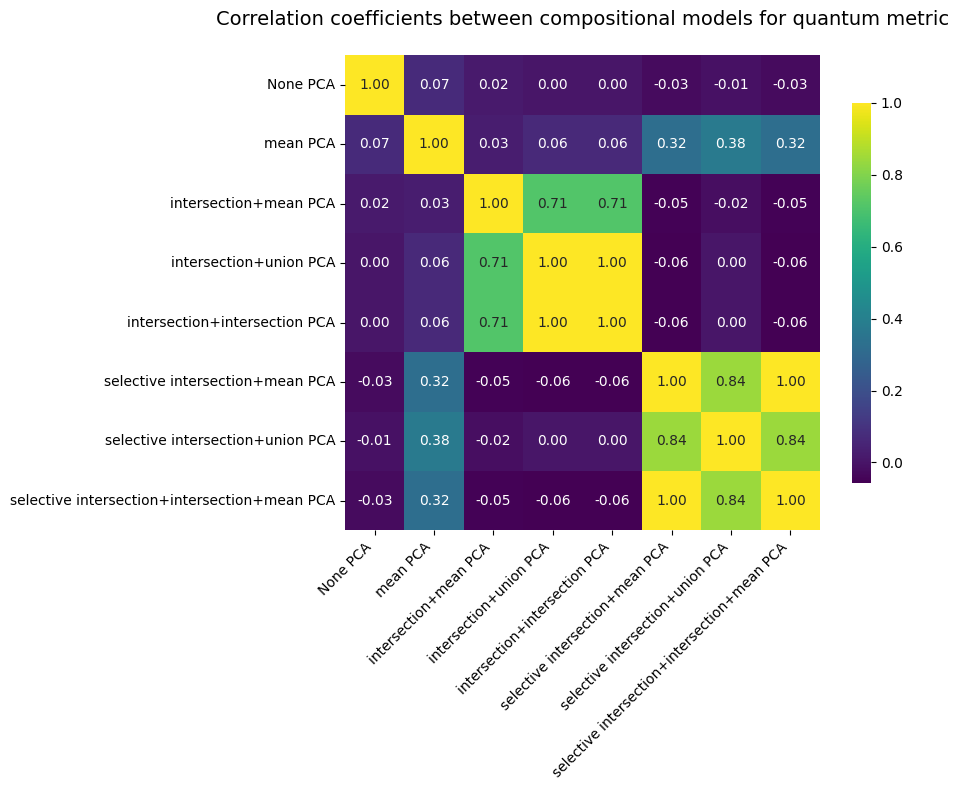

In [28]:
# Create correlation heatmaps for each metric
for sim_metric in sim_metrics:
    # Get prediction columns for this metric
    metric_pred_cols = [c for c in sim_eval_df.columns if c.endswith(f"{sim_metric}_sim_pred")] + ["is_related"]
    # filter to just PCA columns, to avoid an eyesore
    metric_pred_cols = [c for c in metric_pred_cols if "_PCA" in c]

    if len(metric_pred_cols) <= 1:
        continue
    
    # Calculate correlation matrix
    corr_matrix = sim_eval_df[metric_pred_cols].corr()
    
    # Create figure with proper size
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        ax=ax,
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    
    # Simplify labels
    labels = [
        label.replace(f"fuzzy_", "")\
            .replace(f"_{sim_metric}_sim_pred", "")\
            .replace("_", " ")
        for label in corr_matrix.columns
    ]
    
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(labels, rotation=0, fontsize=10)
    
    plt.title(f"Correlation coefficients between compositional models for {sim_metric} metric\n", fontsize=14)
    plt.tight_layout()
    plt.show()

## F1, Recall, Precision, Accuracy, etc.

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create evaluation metrics dataframe for ALL similarity metrics
metrics_data = []

for col in sim_eval_df.columns:
    if col == "is_related":
        continue
    y_true = sim_eval_df['is_related']
    y_pred = sim_eval_df[col].astype(int)
    
    # Extract metric name from column
    metric_name = None
    for sim_metric in sim_metrics:
        if f"_{sim_metric}_sim_pred" in col:
            metric_name = sim_metric
            break
        
    strategy = col.replace('_pred', '').replace(f'_{metric_name}_sim', '').replace('fuzzy_', '')
    
    metrics_data.append({
        'strategy': strategy,
        'similarity_metric': metric_name,
        'model': col.replace('_pred', ''),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values(['f1_score', 'similarity_metric', ], ascending=[False, True]).reset_index(drop=True)
metrics_df[:10]

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,sent_emb,cos,sent_emb_cos_sim,0.606485,0.606485,0.606485,0.606485
1,None_PCA,wasserstein-1,fuzzy_None_PCA_wasserstein-1_sim,0.598379,0.598379,0.598379,0.598379
2,None_PCA,quantum,fuzzy_None_PCA_quantum_sim,0.597273,0.597273,0.597273,0.597273
3,sbert_token_avg,cos,sbert_token_avg_cos_sim,0.584377,0.584377,0.584377,0.584377
4,None_PCA,cos,fuzzy_None_PCA_cos_sim,0.578482,0.578482,0.578482,0.578482
5,intersection+union_PCA,quantum,fuzzy_intersection+union_PCA_quantum_sim,0.542741,0.542741,0.542741,0.542741
6,intersection+intersection_PCA,quantum,fuzzy_intersection+intersection_PCA_quantum_sim,0.542741,0.542741,0.542741,0.542741
7,intersection+mean_PCA,quantum,fuzzy_intersection+mean_PCA_quantum_sim,0.540162,0.540162,0.540162,0.540162
8,None_PCA,wasserstein-2,fuzzy_None_PCA_wasserstein-2_sim,0.538688,0.538688,0.538688,0.538688
9,intersection+union_PCA,wasserstein-1,fuzzy_intersection+union_PCA_wasserstein-1_sim,0.520450,0.520457,0.520265,0.520361


In [30]:
# Create bar graphs for each similarity metric
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# Define colors for each similarity metric
# sim_metric_colors = {
#     'npsd-ot': 'steelblue',
#     'p-ot': 'coral',
#     'cos': 'mediumseagreen'
# }

In [31]:
# Get baseline values
baseline_data = metrics_df[metrics_df['strategy'] == 'sent_emb']
sbert_token_data = metrics_df[metrics_df['strategy'] == 'sbert_token_avg']

baseline_values = {
    'accuracy': baseline_data['accuracy'].values[0] if len(baseline_data) > 0 else None,
    'precision': baseline_data['precision'].values[0] if len(baseline_data) > 0 else None,
    'recall': baseline_data['recall'].values[0] if len(baseline_data) > 0 else None,
    'f1_score': baseline_data['f1_score'].values[0] if len(baseline_data) > 0 else None
}

sbert_token_values = {
    'accuracy': sbert_token_data['accuracy'].values[0] if len(sbert_token_data) > 0 else None,
    'precision': sbert_token_data['precision'].values[0] if len(sbert_token_data) > 0 else None,
    'recall': sbert_token_data['recall'].values[0] if len(sbert_token_data) > 0 else None,
    'f1_score': sbert_token_data['f1_score'].values[0] if len(sbert_token_data) > 0 else None
}

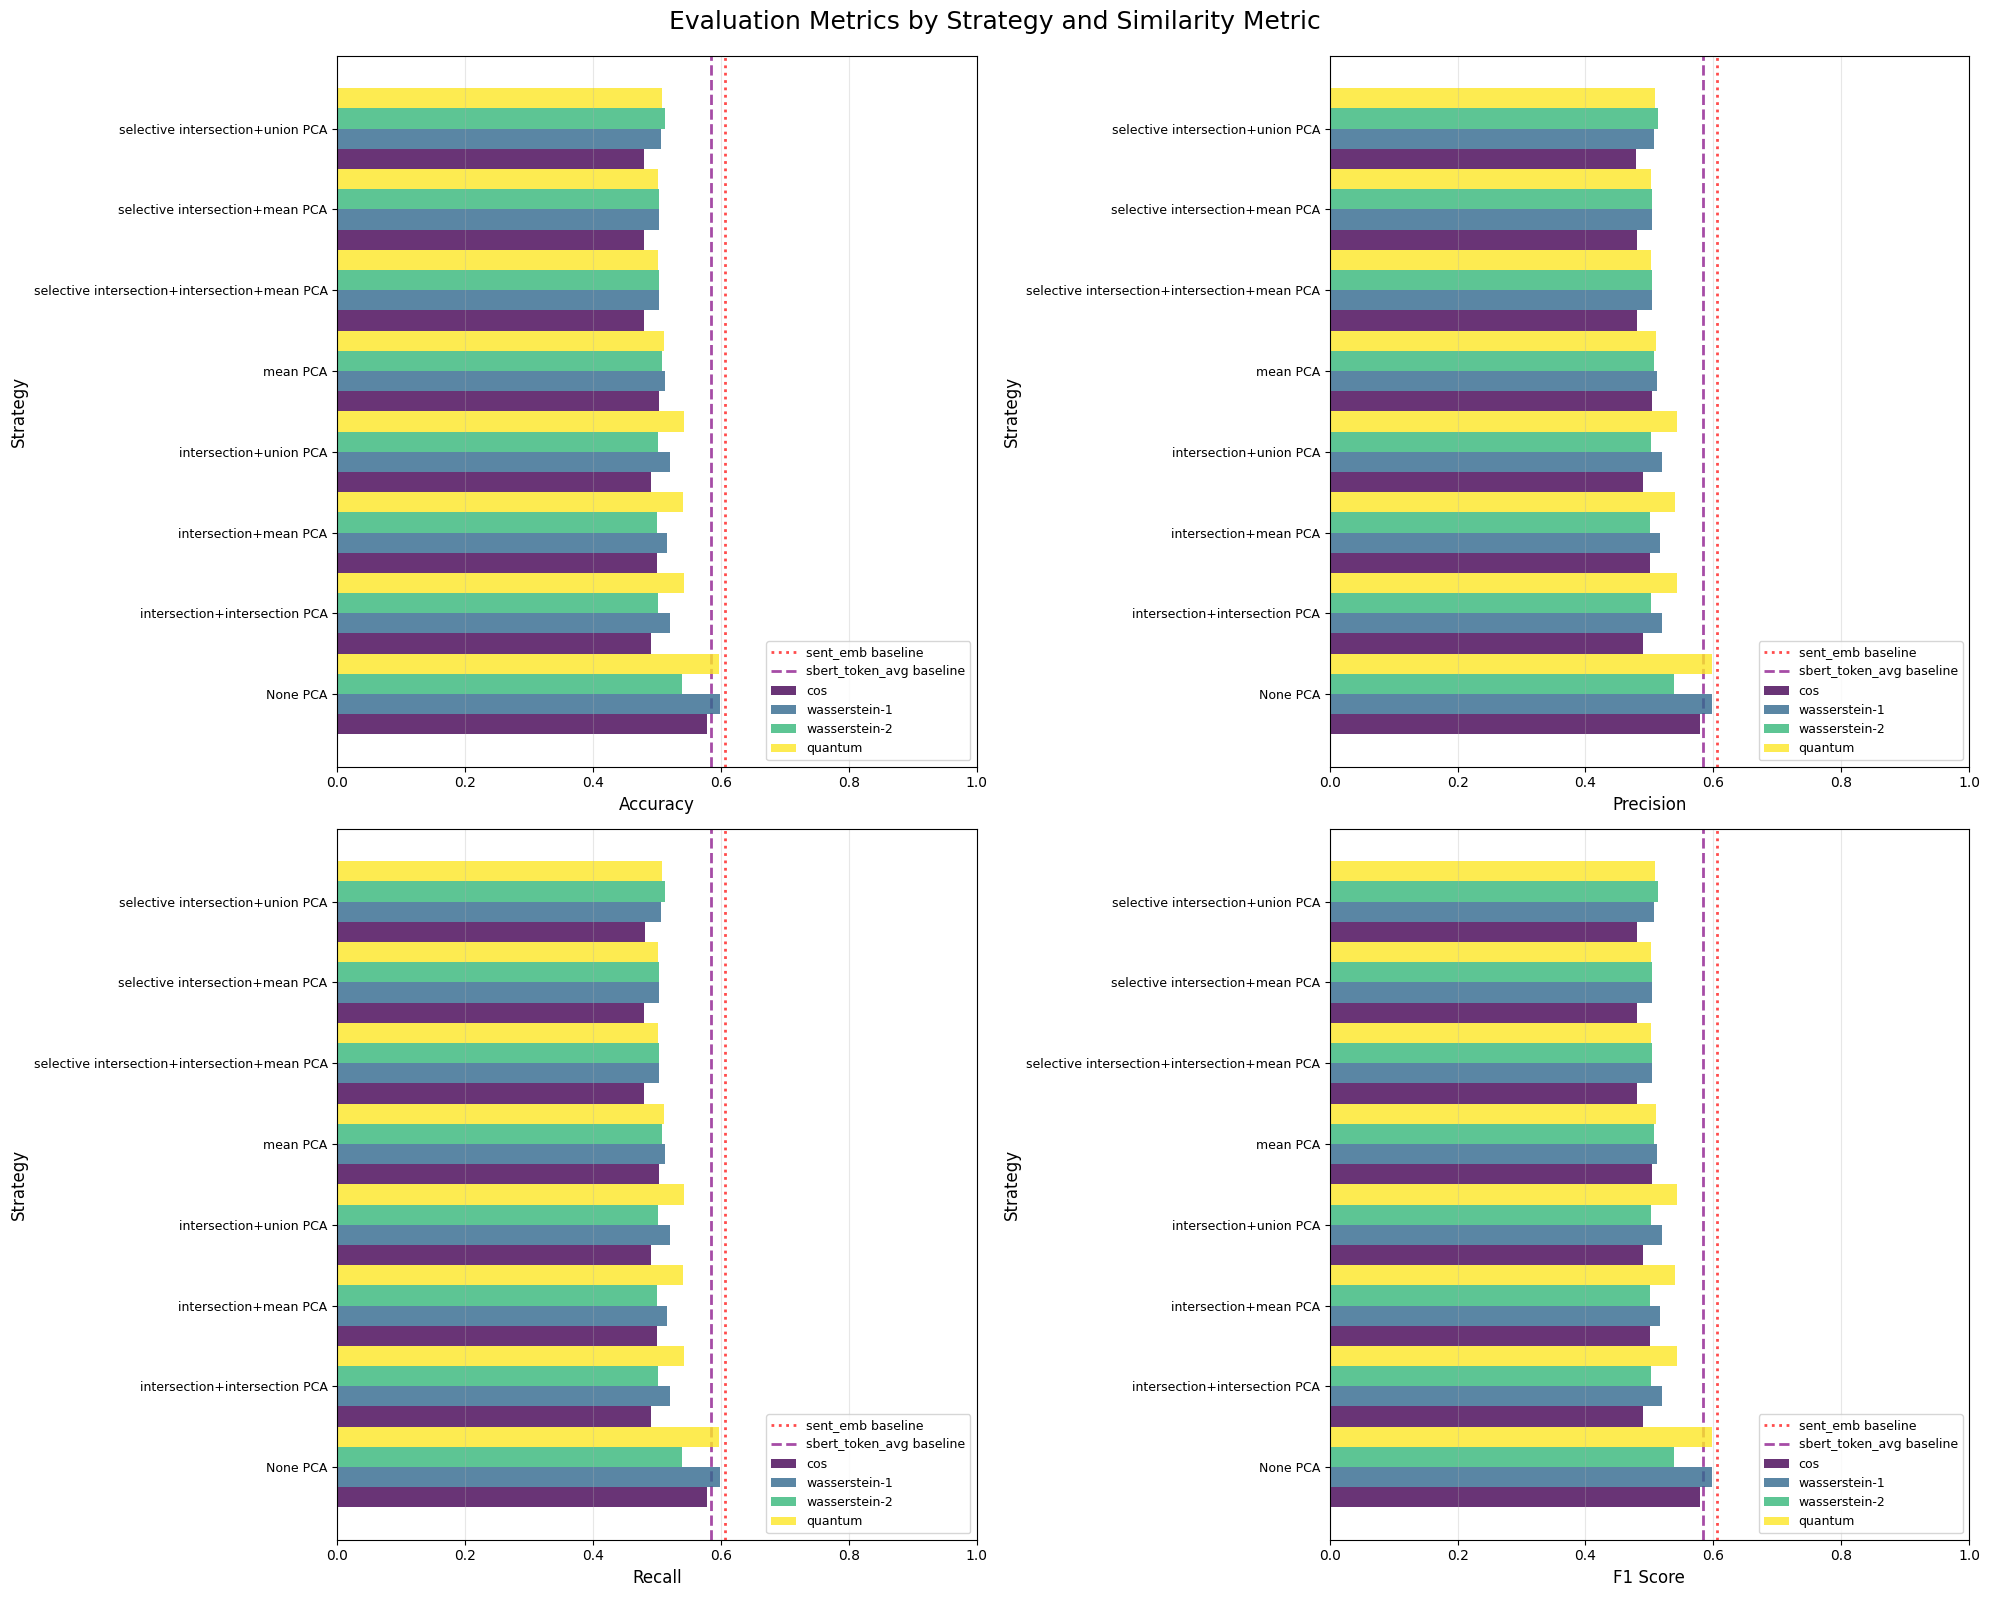

In [32]:
# Get all unique strategies (excluding baselines and None strategy)
all_strategies = sorted(metrics_df[
    (~metrics_df['strategy'].isin(['sent_emb', 'sbert_token_avg', 'None']))
]['strategy'].unique())

# Create one figure with 4 subplots (one for each metric)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Evaluation Metrics by Strategy and Similarity Metric', fontsize=18, y=0.995)

# Create a viridis color map for similarity metrics
cmap = plt.cm.viridis
sim_metric_colors = {
    sim_metric: cmap(i / max(len(sim_metrics) - 1, 1))
    for i, sim_metric in enumerate(sim_metrics)
}

for idx, (metric, title) in enumerate(zip(metric_names, metric_titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data for grouped bar chart
    bar_width = 0.25
    x_pos = np.arange(len(all_strategies))
    
    # Plot bars for each similarity metric
    for i, sim_metric in enumerate(sim_metrics):
        metric_data = metrics_df[
            (metrics_df['similarity_metric'] == sim_metric) & 
            (metrics_df['strategy'].isin(all_strategies))
        ].set_index('strategy')
        
        # Reindex to match all_strategies order
        metric_data = metric_data.reindex(all_strategies)
        values = metric_data[metric].values
        
        # Plot bars with offset
        offset = (i - len(sim_metrics)/2 + 0.5) * bar_width
        bars = ax.barh(
            x_pos + offset,
            values,
            bar_width,
            label=sim_metric,
            color=sim_metric_colors[sim_metric],
            alpha=0.8
        )

    
    # Add baseline lines
    if baseline_values[metric] is not None:
        ax.axvline(x=baseline_values[metric], color='red', linestyle=':', linewidth=2,
                  label='sent_emb baseline', alpha=0.7, zorder=0)
    
    if sbert_token_values[metric] is not None:
        ax.axvline(x=sbert_token_values[metric], color='purple', linestyle='--', linewidth=2,
                  label='sbert_token_avg baseline', alpha=0.7, zorder=0)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels([s.replace('_', ' ') for s in all_strategies], fontsize=9)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel('Strategy', fontsize=12)
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
metrics_df.to_csv(f"full_train_eval-wn_enriched-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")